# Simple IMU Based Classification for QuadCopter Data

To keep it simple to start, we are going to be using four different flights in order to train a CNN/LSTM based model to classify between flights that are in theory circular (I guess nascar level circular) as well as flights that are figure 8 (lemniscate) shaped

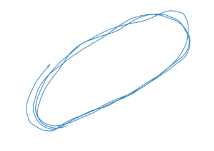
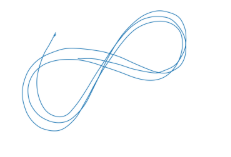

## Imports

- Need to ensure you have an available Nvidia based GPU with the required drivers / toolkit

In [114]:
import bagpy
from bagpy import bagreader

# Data processing
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ML - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Sklearn for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Utilities
import os
import glob
import pickle
import subprocess

# Check PyTorch and GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5070


## Paths


In [115]:
RING_BAG_DIR = 'data/ring/ros'
LEMN_BAG_DIR = 'data/lemniscate/ros'

BASE_DIR = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip()

OUTPUT_DIR = os.path.join(BASE_DIR, "output")
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, "flight_classifier.pth")  # Changed to .pth for PyTorch
ONNX_MODEL_PATH = os.path.join(OUTPUT_DIR, "model.onnx")
ONNX_QUANT_PATH = os.path.join(OUTPUT_DIR, "model_quant.onnx")
SCALER_PATH = os.path.join(OUTPUT_DIR, "scaler.pkl")

os.makedirs(OUTPUT_DIR, exist_ok=True)

## Topics of the data

In [116]:
ring_bags, lemn_bags = glob.glob(os.path.join(RING_BAG_DIR, "*.bag")), glob.glob(os.path.join(LEMN_BAG_DIR, "*.bag"))
print(f'Ring Bags {ring_bags}')
print(f'Lemniscate Bags {lemn_bags}')

sample_bag = ring_bags[0]  # or your specific path
print(f"Inspecting: {sample_bag}\n")

bag = bagreader(sample_bag)

# Show all topics with message counts and types
print("Available topics:")
print(bag.topic_table)


bag_files = glob.glob(os.path.join(LEMN_BAG_DIR, "*.bag"))

sample_bag = lemn_bags[0]  # or your specific path
print(f"Inspecting: {sample_bag}\n")

bag = bagreader(sample_bag)

# Show all topics with message counts and types
print("Available topics:")
print(bag.topic_table)


Ring Bags ['data/ring/ros/indoor_forward_5_davis_with_gt.bag', 'data/ring/ros/indoor_forward_6_davis_with_gt.bag']
Lemniscate Bags ['data/lemniscate/ros/indoor_forward_10_davis_with_gt.bag', 'data/lemniscate/ros/indoor_forward_9_davis_with_gt.bag']
Inspecting: data/ring/ros/indoor_forward_5_davis_with_gt.bag

[INFO]  Data folder data/ring/ros/indoor_forward_5_davis_with_gt already exists. Not creating.
Available topics:
                  Topics                      Types  Message Count   Frequency
0            /dvs/events        dvs_msgs/EventArray           4406   33.330981
1         /dvs/image_raw          sensor_msgs/Image           4787   33.155898
2               /dvs/imu            sensor_msgs/Imu         146701  999.119581
3  /groundtruth/odometry          nav_msgs/Odometry           9650  499.976636
4      /groundtruth/pose  geometry_msgs/PoseStamped           9650  499.976636
Inspecting: data/lemniscate/ros/indoor_forward_10_davis_with_gt.bag

[INFO]  Data folder data/lemnisca

## Topics

Although the data does contain image information, for now it will be limited to IMU/Ground_truth/Odometry data for the sake of this pipeline, other pipelines will include image based information for sensor fusion. 

In [117]:
TOPICS = {
    "imu": "/dvs/imu",                      # 1000Hz IMU data
    "ground_truth": "/groundtruth/pose",    # 500Hz pose (for labeling/validation)
    "odometry": "/groundtruth/odometry",    # 500Hz odom (has velocity too)
    # "events": "/dvs/events",              # DVS events - optional, complex to use
    # "image": "/dvs/image_raw",            # DVS frames - optional
}

## Signal Processing Hyperparameters

#### Sampling Rate
- The sampling rate downsamples the IMU data, which was originally 1000Hz to 100Hz, this reduces computational load while preserving motion dynamics, and is sufficient for quadcopter flight pattern classification
#### Lowpass Cutoff
- Anti Aliasing filter cutoff frequency before downsampling. It removes high frequency noise and prevents aliasing artifacts. It is set below the Nyquist frequency
#### Lowpass Order
- Fourth order butterworth filter, which balances sharp frequency cutoff vs. phase distortion. The higher order means there is a steeper rolloff but more computational cost

In [118]:
SAMPLING_RATE = 100
LOWPASS_CUTOFF = 30
LOWPASS_ORDER = 4

## Sequence / Windowing Hyperparameters
- Each input sequence is 100 timesteps x 6 features (100, 6) shape. At 100 Hz sampling, this represents 1 second of flight data, long enough to capture flight pattern characteristics
- The sliding window moves 25 timesteps (.25 seconds) between sequences, creating a 75% overlap between consecutive windows. This generates more training samples from limited flight data, and helps the model see patterns at different time offsets

In [119]:
SEQUENCE_LENGTH = 150
SEQUENCE_STRIDE = 10

## Feature Configuration

In [120]:
# IMU features from /dvs/imu (sensor_msgs/Imu)
USE_IMU_ACCEL = True         # linear_acceleration: x, y, z (3 features)
USE_IMU_GYRO = True          # angular_velocity: x, y, z (3 features)
USE_IMU_ORIENTATION = False  # orientation quaternion - often noisy, skip for now

# Ground truth features (for training enrichment - may not have at inference!)
USE_POSITION = False         # Set True only if you'll have position at inference
USE_VELOCITY = False         # Can derive from odometry if needed

# For STM32 deployment, you'll likely only have IMU
# So keep features to what you'll have at inference time
NUM_FEATURES = (
    3 * USE_IMU_ACCEL +      # 3
    3 * USE_IMU_GYRO +       # 3
    4 * USE_IMU_ORIENTATION + # 0
    3 * USE_POSITION +        # 0
    3 * USE_VELOCITY          # 0
)
# = 6 features (accel + gyro)

print(f"Total features per timestep: {NUM_FEATURES}")

Total features per timestep: 6


## Model Architecture Hyperparameters

- The first Convolutional layer contains 16 filters, and the second contains 32 filters. This progressively extracts higher-level features
- Each Convolutional Neural Network filter looks at 3 consecutive timesteps, with a small kernel capturing local temporal patterns effectively
- Maxpooling reduces sequence length by 2x after each conv block, which reduces computational cost and focuses on salient features
- Using the GRU RNN type takes advantage of better STM32Cube.AI support, with fewer parameters than LSTM, while still capturing temporal dependencies in flight patterns
- Using 16 dense units allows for final feature compression before binary classification, and a .3 dropout rate prevents overfitting on limited flight data

In [121]:
CNN_FILTERS = [32, 64, 128]       # Good starting point
CNN_KERNEL_SIZE = 5
CNN_POOL_SIZE = 2

RNN_TYPE = "GRU"             # GRU recommended - better Cube.AI support than LSTM
RNN_UNITS = 32

DENSE_UNITS = 64
DROPOUT_RATE = 0.4

## Training Hyperparameters

- 32 sequences are processed per gradient update, which balances training speed and gradient stability
- 1e-3 as the initial adam optimizer learning rate
- Uses a 70% training, 15% validation and 15% final test split

In [122]:
BATCH_SIZE = 128
EPOCHS = 300
LEARNING_RATE = 3e-4
EARLY_STOPPING_PATIENCE = 30
LR_REDUCE_PATIENCE = 10
LR_REDUCE_FACTOR = 0.3
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

## Quantization

- The number of training samples used for post-training quantization calibration
- Determines optimal INT8 scaling parameters

In [123]:
QUANTIZATION_SAMPLES = 100

## STM32 Target
- This represents the target microcontroller (Nucleo-64 board with ARM Cortex-M4)
- Determines deployment constraints

In [124]:
TARGET_MCU = "STM32F446RE"   # Adjust to your MCU
TARGET_FLASH_KB = 512
TARGET_RAM_KB = 128

## Data Extraction

- The IMU data is extracted from the BAG files for training
- The ground truth information is used for later visualization of flight paths

In [125]:
def extract_imu_data(bag_path):
    """
    Extract IMU data from bag file.
    
    sensor_msgs/Imu contains:
    - header (timestamp)
    - orientation (quaternion)
    - angular_velocity (x, y, z)
    - linear_acceleration (x, y, z)
    """
    bag = bagreader(bag_path)
    
    # Extract IMU topic to CSV (bagpy does this automatically)
    imu_csv = bag.message_by_topic(TOPICS["imu"])
    imu_df = pd.read_csv(imu_csv)
    
    # Print columns to see structure
    print(f"IMU columns: {imu_df.columns.tolist()}")
    
    return imu_df


def extract_ground_truth(bag_path):
    """
    Extract ground truth pose for trajectory visualization.
    
    geometry_msgs/PoseStamped contains:
    - header (timestamp)
    - pose.position (x, y, z)
    - pose.orientation (quaternion)
    """
    bag = bagreader(bag_path)
    
    pose_csv = bag.message_by_topic(TOPICS["ground_truth"])
    pose_df = pd.read_csv(pose_csv)
    
    print(f"Pose columns: {pose_df.columns.tolist()}")
    
    return pose_df


## Data Preprocessing

Preprocess IMU data:
- Extract relevant columns
- Low-pass filter (anti-aliasing)
- Downsample to target rate

In [126]:
def preprocess_imu(imu_df, target_rate=SAMPLING_RATE):


    # Get timestamps (convert to seconds from start)
    time = imu_df['Time'].values
    time = time - time[0]  # Start at 0

    # Extract accel and gyro (only x, y, z - exclude covariance columns)
    # Column names from bagpy: 'linear_acceleration.x', 'angular_velocity.y', etc.

    accel_cols = ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']
    gyro_cols = ['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']

    # Verify columns exist
    missing_cols = [c for c in accel_cols + gyro_cols if c not in imu_df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in IMU data: {missing_cols}")

    print(f"Extracting accel: {accel_cols}")
    print(f"Extracting gyro: {gyro_cols}")

    # Extract data (Shape: (N, 3) each)
    accel = imu_df[accel_cols].values
    gyro = imu_df[gyro_cols].values

    # Combine features
    features = np.hstack([accel, gyro])  # Shape: (N, 6)

    print(f"Combined features shape: {features.shape} (should be N x 6)")

    # Low-pass filter
    original_rate = len(time) / time[-1]
    nyquist = original_rate / 2
    normalized_cutoff = LOWPASS_CUTOFF / nyquist

    if normalized_cutoff < 1:
        b, a = butter(LOWPASS_ORDER, normalized_cutoff, btype='low')
        features_filtered = filtfilt(b, a, features, axis=0)
    else:
        features_filtered = features
        print("Warning: Cutoff frequency too high, skipping filter")

    # Downsample
    target_times = np.arange(0, time[-1], 1/target_rate)

    features_resampled = np.zeros((len(target_times), features.shape[1]))
    for i in range(features.shape[1]):
        interp_func = interp1d(time, features_filtered[:, i],
                                kind='linear', fill_value='extrapolate')
        features_resampled[:, i] = interp_func(target_times)

    return features_resampled, target_times



## Sequence Creation

- This processes 4 bag files, extracts 6 IMU features, and creates sliding window sequences of shape (100, 6)

In [127]:
def create_sequences(features, sequence_length, stride):
    """
    Convert continuous features into overlapping sequences.
    
    Args:
        features: numpy array of shape (total_timesteps, num_features)
        sequence_length: number of timesteps per sequence
        stride: step size between sequences
    
    Returns:
        sequences: numpy array of shape (num_sequences, sequence_length, num_features)
    """
    sequences = []
    
    for i in range(0, len(features) - sequence_length + 1, stride):
        seq = features[i:i + sequence_length]
        sequences.append(seq)
    
    return np.array(sequences)


def process_all_bags(bag_list, label, sequence_length=SEQUENCE_LENGTH, stride=SEQUENCE_STRIDE):
    """
    Process all bag files for one class.
    
    Args:
        bag_list: list of paths to bag files
        label: 0 for oval, 1 for lemniscate
    
    Returns:
        X: sequences array
        y: labels array
    """
    all_sequences = []
    
    for bag_path in bag_list:
        print(f"Processing: {os.path.basename(bag_path)}")
        
        # Extract IMU data
        bag = bagreader(bag_path)
        imu_csv = bag.message_by_topic(TOPICS["imu"])
        imu_df = pd.read_csv(imu_csv)
        
        # Preprocess (filter + downsample)
        features, times = preprocess_imu(imu_df)
        
        # Create sequences
        sequences = create_sequences(features, sequence_length, stride)
        all_sequences.append(sequences)
        
        print(f"  -> {len(sequences)} sequences of shape {sequences.shape[1:]}")
    
    X = np.concatenate(all_sequences, axis=0)
    y = np.full(len(X), label)
    
    return X, y


# Process both classes
print("Processing OVAL bags...")
X_oval, y_oval = process_all_bags(ring_bags, label=0)

print("\nProcessing LEMNISCATE bags...")
X_lemniscate, y_lemniscate = process_all_bags(lemn_bags, label=1)

# Combine
X_all = np.concatenate([X_oval, X_lemniscate], axis=0)
y_all = np.concatenate([y_oval, y_lemniscate], axis=0)

print(f"\n{'='*60}")
print(f"DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total sequences: {len(X_all)}")
print(f"  Oval (0):       {len(y_oval)} ({len(y_oval)/len(y_all)*100:.1f}%)")
print(f"  Lemniscate (1): {len(y_lemniscate)} ({len(y_lemniscate)/len(y_all)*100:.1f}%)")
print(f"Sequence shape:   {X_all.shape[1:]}")
print(f"{'='*60}")



Processing OVAL bags...
Processing: indoor_forward_5_davis_with_gt.bag
[INFO]  Data folder data/ring/ros/indoor_forward_5_davis_with_gt already exists. Not creating.
Extracting accel: ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']
Extracting gyro: ['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']
Combined features shape: (146701, 6) (should be N x 6)
  -> 1454 sequences of shape (150, 6)
Processing: indoor_forward_6_davis_with_gt.bag
[INFO]  Data folder data/ring/ros/indoor_forward_6_davis_with_gt already exists. Not creating.
Extracting accel: ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z']
Extracting gyro: ['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z']
Combined features shape: (70483, 6) (should be N x 6)
  -> 691 sequences of shape (150, 6)

Processing LEMNISCATE bags...
Processing: indoor_forward_10_davis_with_gt.bag
[INFO]  Data folder data/lemniscate/ros/indoor_forward_10_davis_with_gt a

## Data Splitting and Normalization

In [128]:
# Shuffle data
shuffle_idx = np.random.permutation(len(X_all))
X_all = X_all[shuffle_idx]
y_all = y_all[shuffle_idx]

# Split: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train:      {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test:       {len(X_test)} samples")

# -----------------------------------------------------------------------------
# Normalization (CRITICAL for deployment!)
# -----------------------------------------------------------------------------

# DEBUG: Check shapes before fitting
print(f"\nDEBUG - Data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"NUM_FEATURES constant: {NUM_FEATURES}")

# Fit scaler on training data only (prevents data leakage)
# Reshape to 2D for sklearn: (samples * timesteps, features)
# FIXED: Use actual shape instead of hardcoded NUM_FEATURES
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
print(f"X_train_flat shape: {X_train_flat.shape}")

scaler = StandardScaler()
scaler.fit(X_train_flat)

# Save scaler parameters - YOU NEED THESE FOR STM32!
print(f"\nNormalization parameters (save for STM32):")
print(f"Mean: {scaler.mean_}")
print(f"Std:  {scaler.scale_}")

# Apply normalization
def normalize_sequences(X, scaler):
    """Normalize sequences using fitted scaler."""
    original_shape = X.shape
    # FIXED: Use scaler.n_features_in_ to ensure consistency
    num_features = scaler.n_features_in_
    X_flat = X.reshape(-1, num_features)
    print(f"  Normalizing shape {original_shape} -> flat {X_flat.shape}")
    X_normalized = scaler.transform(X_flat)
    return X_normalized.reshape(original_shape)

X_train_norm = normalize_sequences(X_train, scaler)
X_val_norm = normalize_sequences(X_val, scaler)
X_test_norm = normalize_sequences(X_test, scaler)

# Save scaler for deployment
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\nScaler saved to: {SCALER_PATH}")

# Verify normalization
print(f"\nNormalized data statistics (should be ~0 mean, ~1 std):")
print(f"Train mean: {X_train_norm.mean(axis=(0,1))}")
print(f"Train std:  {X_train_norm.std(axis=(0,1))}")

# -----------------------------------------------------------------------------
# PyTorch Data Preparation
# -----------------------------------------------------------------------------

print(f"\n{'='*60}")
print("CONVERTING TO PYTORCH TENSORS")
print(f"{'='*60}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_norm).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)

X_val_tensor = torch.FloatTensor(X_val_norm).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)

X_test_tensor = torch.FloatTensor(X_test_norm).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")
print(f"Device:        {device}")
print(f"{'='*60}")

Train:      2541 samples
Validation: 544 samples
Test:       545 samples

DEBUG - Data shapes:
X_train shape: (2541, 150, 6)
X_val shape: (544, 150, 6)
X_test shape: (545, 150, 6)
NUM_FEATURES constant: 6
X_train_flat shape: (381150, 6)

Normalization parameters (save for STM32):
Mean: [  0.72902851 -10.40185206   0.49020769   0.05711849  -0.1900255
  -0.09077686]
Std:  [0.87293054 2.02680749 0.89424613 0.32002564 0.59251341 0.56589751]
  Normalizing shape (2541, 150, 6) -> flat (381150, 6)
  Normalizing shape (544, 150, 6) -> flat (81600, 6)
  Normalizing shape (545, 150, 6) -> flat (81750, 6)

Scaler saved to: /home/lucassecretaccount/IMU-TFLM-ML/output/scaler.pkl

Normalized data statistics (should be ~0 mean, ~1 std):
Train mean: [-3.14613058e-14 -1.77180794e-14  8.02342960e-15 -6.28616229e-15
  5.32309690e-15 -1.64717599e-15]
Train std:  [1. 1. 1. 1. 1. 1.]

CONVERTING TO PYTORCH TENSORS
Train batches: 20
Val batches:   5
Test batches:  5
Device:        cuda


## Model Definition

- Type: CNN-GRU Hybrid
- Purpose: Binary classification (Oval vs Lemniscate flight patterns)
- Optimization Target: STM32 embedded deployment


Key Design Choices for STM32

1. GRU over LSTM
- Why: Fewer parameters than LSTM (6,336 vs ~8,500)
- Better STM32Cube.AI support
- Still captures temporal patterns effectively
2. Small Filter Counts (16, 32)
- Minimizes memory footprint
- Sufficient for IMU signal patterns
- Keeps model under 512KB flash constraint
3. BatchNormalization
- Improves training stability
- Critical: Folds into Conv weights at deployment (no runtime cost)
4. MaxPooling Between Conv Blocks
- Reduces sequence length 100 → 50 → 25
- Decreases GRU computational load by 4×
- Focuses on salient features
5. Conservative Dropout (0.3)
- Prevents overfitting on limited flight data (only 4 bag files)
- Balances generalization vs. underfitting


In [129]:
class FlightClassifier(nn.Module):
    """
    CNN-GRU model optimized for STM32 deployment (PyTorch version).
    
    Architecture:
    Input -> Conv1D -> BatchNorm -> Pool -> Conv1D -> BatchNorm -> Pool 
          -> GRU -> Dropout -> Dense -> Dropout -> Output
    
    Design choices for STM32:
    - GRU instead of LSTM (fewer parameters, better Cube.AI support)
    - Small filter counts (16, 32)
    - BatchNorm for training stability (folds into Conv at deployment)
    - MaxPooling to reduce sequence length before RNN
    """
    
    def __init__(
        self,
        sequence_length=SEQUENCE_LENGTH,
        num_features=NUM_FEATURES,
        cnn_filters=CNN_FILTERS,
        kernel_size=CNN_KERNEL_SIZE,
        pool_size=CNN_POOL_SIZE,
        rnn_units=RNN_UNITS,
        dense_units=DENSE_UNITS,
        dropout_rate=DROPOUT_RATE
    ):
        super(FlightClassifier, self).__init__()
        
        self.sequence_length = sequence_length
        self.num_features = num_features
        
        # --- CNN Feature Extraction ---
        # First conv block
        # Note: PyTorch Conv1d expects (batch, channels, length)
        # We'll need to permute input from (batch, length, channels)
        self.conv1 = nn.Conv1d(
            in_channels=num_features,
            out_channels=cnn_filters[0],
            kernel_size=kernel_size,
            padding=kernel_size//2  # 'same' padding
        )
        self.bn1 = nn.BatchNorm1d(cnn_filters[0])
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=pool_size)
        
        # Second conv block
        self.conv2 = nn.Conv1d(
            in_channels=cnn_filters[0],
            out_channels=cnn_filters[1],
            kernel_size=kernel_size,
            padding=kernel_size//2
        )
        self.bn2 = nn.BatchNorm1d(cnn_filters[1])
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=pool_size)
        
        # Calculate sequence length after pooling
        seq_after_pool = sequence_length // (pool_size ** 2)
        
        # --- Temporal Modeling ---
        # GRU: input shape (batch, seq_len, input_size)
        self.gru = nn.GRU(
            input_size=cnn_filters[1],
            hidden_size=rnn_units,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # --- Classification Head ---
        self.dense1 = nn.Linear(rnn_units, dense_units)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output: single neuron with sigmoid for binary classification
        self.output = nn.Linear(dense_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch, sequence_length, num_features)
            
        Returns:
            Output tensor of shape (batch, 1) with sigmoid probabilities
        """
        # Input: (batch, seq_len, features)
        # Conv1d expects: (batch, features, seq_len)
        x = x.permute(0, 2, 1)
        
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Prepare for GRU: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        
        # GRU (we only use the last output)
        _, h_n = self.gru(x)
        x = h_n[-1]  # Get last hidden state
        x = self.dropout1(x)
        
        # Classification head
        x = self.dense1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        
        # Output
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters."""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable


# Create model
model = FlightClassifier().to(device)

# Summary
print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
print(model)
print()

# Calculate model size estimate
total_params, trainable_params = model.count_parameters()
estimated_size_kb = total_params * 4 / 1024  # float32 = 4 bytes
quantized_size_kb = total_params * 1 / 1024  # int8 = 1 byte

print(f"{'='*60}")
print(f"MODEL SIZE ESTIMATES")
print(f"{'='*60}")
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Float32 size:         ~{estimated_size_kb:.1f} KB")
print(f"Int8 quantized size:  ~{quantized_size_kb:.1f} KB")
print(f"Target Flash:         {TARGET_FLASH_KB} KB")
print(f"{'='*60}")

MODEL ARCHITECTURE
FlightClassifier(
  (conv1): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(64, 32, batch_first=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (dense1): Linear(in_features=32, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

MODEL SIZE ESTIMATES
Total parameters:     23,073
Trainable parameters: 23,073
Float32 size:         ~90.1 KB
Int8 quantized size:  ~22.5 KB

  ## Training (PyTorch)

  This cell implements the complete training loop with the following features:

  **Loss & Optimization:**
  - Binary Cross-Entropy (BCE) loss for binary classification
  - Adam optimizer with initial learning rate of 1e-3
  - Class weighting to handle imbalanced dataset (59% oval, 41% lemniscate)

  **Training Strategies:**
  - **Early stopping**: Stops training if validation loss doesn't improve for 15 epochs
  - **Learning rate scheduling**: Reduces LR by 0.5× after 7 epochs without improvement
  - **Best model saving**: Automatically saves the model with lowest validation loss

  **Training Process:**
  - Trains for up to 100 epochs (typically stops early around 40-60 epochs)
  - Batch size: 32 sequences
  - Prints progress every 5 epochs
  - Tracks loss and accuracy for both training and validation sets

In [130]:
# -----------------------------------------------------------------------------
# Training Setup
# -----------------------------------------------------------------------------

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=LR_REDUCE_FACTOR,
    patience=LR_REDUCE_PATIENCE,
    min_lr=1e-6
)

# Handle class imbalance with weighted loss
class_counts = np.bincount(y_train.astype(int))
total = len(y_train)
class_weights_dict = {
    0: total / (2 * class_counts[0]),
    1: total / (2 * class_counts[1])
}
print(f"Class weights: {class_weights_dict}")

# Create weight tensor for samples
sample_weights = torch.FloatTensor([class_weights_dict[int(label)] for label in y_train]).to(device)

# Weighted BCE Loss
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
        
    def forward(self, outputs, targets, indices):
        loss = nn.functional.binary_cross_entropy(outputs, targets, reduction='none')
        weighted_loss = loss * self.weights[indices]
        return weighted_loss.mean()

weighted_criterion = WeightedBCELoss(sample_weights)

# -----------------------------------------------------------------------------
# Training Loop
# -----------------------------------------------------------------------------

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("\nStarting training...")
print(f"{'='*60}")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Get sample indices for weighted loss
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, len(X_train_tensor))
        batch_indices = torch.arange(start_idx, end_idx, device=device)
        
        # Forward pass
        outputs = model(inputs)
        loss = weighted_criterion(outputs, targets, batch_indices)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * inputs.size(0)
        predictions = (outputs >= 0.5).float()
        train_correct += (predictions == targets).sum().item()
        train_total += targets.size(0)
    
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            predictions = (outputs >= 0.5).float()
            val_correct += (predictions == targets).sum().item()
            val_total += targets.size(0)
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # Save history
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    if new_lr < old_lr:
        print(f"\nReducing learning rate to {new_lr:.6f}")
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        # Save best model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    else:
        patience_counter += 1
        
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nRestored best model with val_loss: {best_val_loss:.4f}")

print("\nTraining complete!")
print(f"{'='*60}")

Class weights: {0: np.float64(0.846435709526982), 1: np.float64(1.2216346153846154)}

Starting training...
Epoch [1/300] Train Loss: 0.6834, Train Acc: 0.5494 | Val Loss: 0.6665, Val Acc: 0.6820
Epoch [5/300] Train Loss: 0.5547, Train Acc: 0.7135 | Val Loss: 0.5386, Val Acc: 0.7426
Epoch [10/300] Train Loss: 0.3661, Train Acc: 0.8162 | Val Loss: 0.3285, Val Acc: 0.8346
Epoch [15/300] Train Loss: 0.2681, Train Acc: 0.8800 | Val Loss: 0.2324, Val Acc: 0.8934
Epoch [20/300] Train Loss: 0.2209, Train Acc: 0.9044 | Val Loss: 0.1943, Val Acc: 0.9191
Epoch [25/300] Train Loss: 0.1792, Train Acc: 0.9213 | Val Loss: 0.1464, Val Acc: 0.9393
Epoch [30/300] Train Loss: 0.1575, Train Acc: 0.9276 | Val Loss: 0.1162, Val Acc: 0.9540
Epoch [35/300] Train Loss: 0.1364, Train Acc: 0.9323 | Val Loss: 0.0929, Val Acc: 0.9577
Epoch [40/300] Train Loss: 0.1270, Train Acc: 0.9418 | Val Loss: 0.0977, Val Acc: 0.9577
Epoch [45/300] Train Loss: 0.1076, Train Acc: 0.9520 | Val Loss: 0.0720, Val Acc: 0.9724
Epoch

## Training Visualization

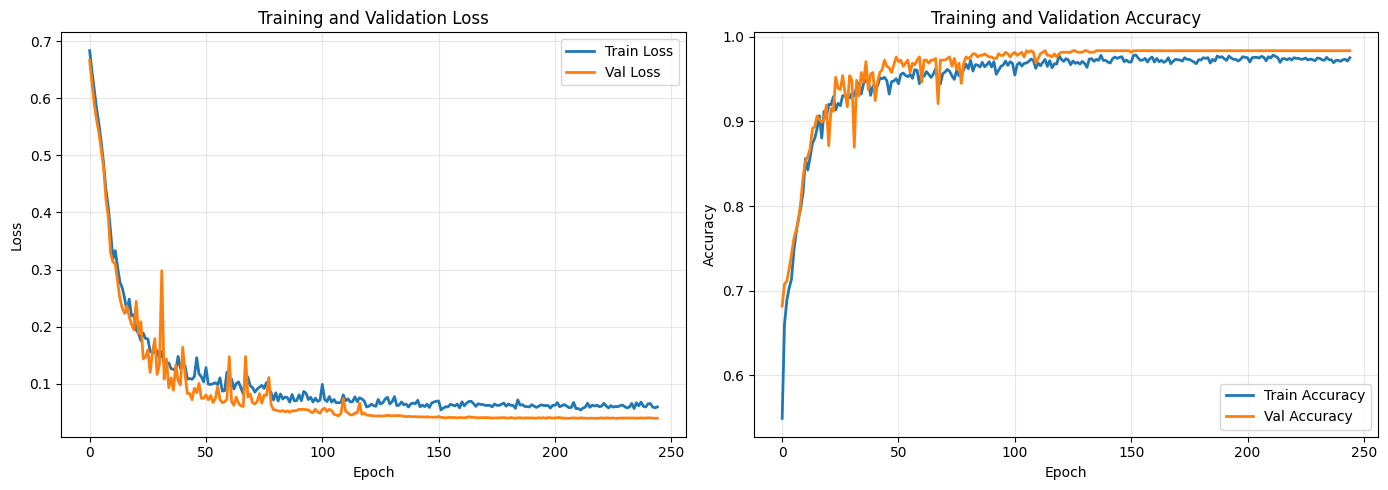


Final Training Accuracy:   0.9752
Final Validation Accuracy: 0.9835


In [131]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy:   {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

## Model Evaluation

Test Loss:     0.0521
Test Accuracy: 0.9798

Classification Report:
              precision    recall  f1-score   support

        Oval       0.99      0.98      0.98       322
  Lemniscate       0.97      0.98      0.98       223

    accuracy                           0.98       545
   macro avg       0.98      0.98      0.98       545
weighted avg       0.98      0.98      0.98       545



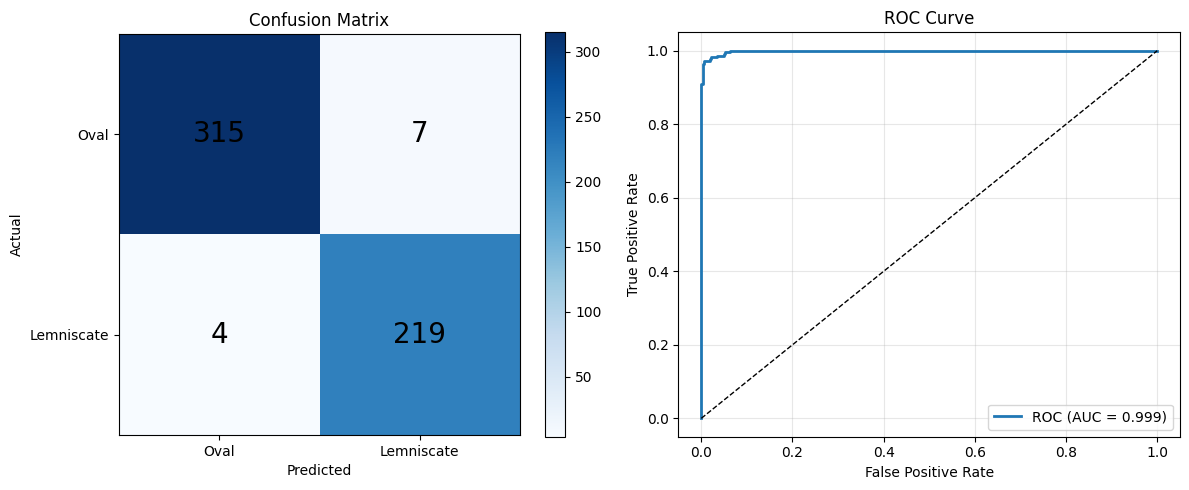

In [132]:
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc
)

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH.replace('.keras', '.pth')))
model.eval()

# Evaluate on test set
test_loss = 0.0
test_correct = 0
test_total = 0
y_pred_prob = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item() * inputs.size(0)
        predictions = (outputs >= 0.5).float()
        test_correct += (predictions == targets).sum().item()
        test_total += targets.size(0)
        
        # Store probabilities for ROC curve
        y_pred_prob.extend(outputs.cpu().numpy())

test_loss = test_loss / test_total
test_acc = test_correct / test_total

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred_prob = np.array(y_pred_prob).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Oval', 'Lemniscate']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix plot
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Oval', 'Lemniscate'])
axes[0].set_yticklabels(['Oval', 'Lemniscate'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=20)

plt.colorbar(im, ax=axes[0])

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'evaluation_results.png'), dpi=150)
plt.show()

## Validate ONNX Inference

In [137]:
  # =============================================================================
  # ONNX Export & Validation (FAST VERSION)
  # =============================================================================

print("=" * 80)
print("EXPORTING MODEL TO ONNX")
print("=" * 80)

# STEP 1: Export to ONNX
model.eval()
dummy_input = torch.randn(1, SEQUENCE_LENGTH, NUM_FEATURES).to(device)

torch.onnx.export(
    model,
    dummy_input,
    ONNX_MODEL_PATH,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

onnx_size_kb = os.path.getsize(ONNX_MODEL_PATH) / 1024
print(f"✓ Exported: {ONNX_MODEL_PATH} ({onnx_size_kb:.2f} KB)")

# Verify structure
import onnx
onnx_model = onnx.load(ONNX_MODEL_PATH)
onnx.checker.check_model(onnx_model)
print("✓ Model structure verified")

# STEP 2: Quick Validation (20 samples in batch - FAST!)
print("\n" + "=" * 80)
print("VALIDATING ONNX MODEL")
print("=" * 80)

try:
    import onnxruntime as ort

    ort_session = ort.InferenceSession(ONNX_MODEL_PATH)
    test_batch = X_test_norm[:20].astype(np.float32)

    # PyTorch
    with torch.no_grad():
        pytorch_out = model(torch.FloatTensor(test_batch).to(device)).cpu().numpy().flatten()

    # ONNX (BATCH MODE - processes all 20 at once)
    onnx_out = ort_session.run(None, {'input': test_batch})[0].flatten()

    max_diff = np.abs(pytorch_out - onnx_out).max()
    print(f"Max difference: {max_diff:.8f}")
    print("✓ ONNX validated" if max_diff < 1e-3 else "⚠ Large difference detected")

    # STEP 3: Quantization (FAST - no per-sample validation)
    print("\n" + "=" * 80)
    print("QUANTIZING TO INT8")
    print("=" * 80)

    try:
        from onnxruntime.quantization import quantize_dynamic, QuantType

        quantize_dynamic(ONNX_MODEL_PATH, ONNX_QUANT_PATH, weight_type=QuantType.QInt8)
        quant_size_kb = os.path.getsize(ONNX_QUANT_PATH) / 1024

        print(f"✓ Quantized: {ONNX_QUANT_PATH} ({quant_size_kb:.2f} KB)")
        print(f"  Compression: {onnx_size_kb/quant_size_kb:.1f}x")

        # Quick accuracy check (batch mode)
        quant_session = ort.InferenceSession(ONNX_QUANT_PATH)
        quant_out = quant_session.run(None, {'input': test_batch})[0].flatten()

        pytorch_acc = np.mean((pytorch_out > 0.5).astype(int) == y_test[:20])
        quant_acc = np.mean((quant_out > 0.5).astype(int) == y_test[:20])

        print(f"  PyTorch acc: {pytorch_acc:.3f}")
        print(f"  Quantized acc: {quant_acc:.3f}")
        print(f"  Acc drop: {pytorch_acc - quant_acc:.3f}")

    except Exception as e:
        print(f"⚠ Quantization skipped: {e}")

except ImportError:
    print("⚠ onnxruntime not installed (pip install onnxruntime)")

# STEP 4: Summary
print("\n" + "=" * 80)
print("DEPLOYMENT READY")
print("=" * 80)
print(f"""
Files:
{ONNX_MODEL_PATH} ({onnx_size_kb:.1f} KB)
{SCALER_PATH}

Normalization for STM32:
Mean: [{', '.join(f'{x:.3f}' for x in scaler.mean_)}]
Std:  [{', '.join(f'{x:.3f}' for x in scaler.scale_)}]

Model: ({SEQUENCE_LENGTH}, {NUM_FEATURES}) → (1,)
Accuracy: {test_acc:.2%}

Import into STM32Cube.AI → Generate Code → Deploy!
""")


EXPORTING MODEL TO ONNX


/tmp/ipykernel_64409/3837016059.py:13: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


KeyboardInterrupt: 

## Quantize to INT8 for STM32

In [ ]:
print("\n" + "=" * 80)
print("STEP 3: QUANTIZING TO INT8")
print("=" * 80)

try:
    from onnxruntime.quantization import quantize_dynamic, QuantType

    print("\nApplying dynamic INT8 quantization...")

    # Quantize model
    quantize_dynamic(
        ONNX_MODEL_PATH,
        ONNX_QUANT_PATH,
        weight_type=QuantType.QInt8
    )

    quant_size_kb = os.path.getsize(ONNX_QUANT_PATH) / 1024
    compression_ratio = onnx_size_kb / quant_size_kb

    print(f"✓ Quantized model saved to: {ONNX_QUANT_PATH}")
    print(f"\nQuantization Results:")
    print(f"  Original size:  {onnx_size_kb:.2f} KB")
    print(f"  Quantized size: {quant_size_kb:.2f} KB")
    print(f"  Compression:    {compression_ratio:.2f}x")

    # Validate quantized model
    print("\nValidating quantized model...")
    quant_session = ort.InferenceSession(ONNX_QUANT_PATH)

    quant_predictions = []
    for i in range(len(X_test_norm)):
        sample = X_test_norm[i:i+1].astype(np.float32)
        quant_output = quant_session.run(None, {'input': sample})[0]
        quant_predictions.append(quant_output[0, 0])
    quant_predictions = np.array(quant_predictions)

    quant_pred_class = (quant_predictions > 0.5).astype(int)
    quant_acc = np.mean(quant_pred_class == y_test)

    quant_max_diff = np.abs(pytorch_predictions - quant_predictions).max()
    quant_mean_diff = np.abs(pytorch_predictions - quant_predictions).mean()

    print(f"\nQuantized Model Performance:")
    print(f"  Accuracy:        {quant_acc:.4f}")
    print(f"  Acc drop:        {pytorch_acc - quant_acc:.4f}")
    print(f"  Max diff:        {quant_max_diff:.4f}")
    print(f"  Mean diff:       {quant_mean_diff:.4f}")

    if abs(pytorch_acc - quant_acc) < 0.02:
        print("\n✓ Quantization preserves accuracy well (<2% drop)")
    else:
        print("\n⚠ Warning: Quantization causes >2% accuracy drop")

except ImportError:
    print("\n⚠ onnxruntime.quantization not available")
    print("Install with: pip install onnxruntime")
    print("\nNote: STM32Cube.AI can also perform quantization during conversion")

## Inference Time Benchmarking

In [ ]:
print("\n" + "=" * 80)
print("STEP 4: INFERENCE TIME BENCHMARKING")
print("=" * 80)

import time
try:
    # Benchmark PyTorch
    warmup_samples = X_test_norm[:10]
    model.eval()
    with torch.no_grad():
        for sample in warmup_samples:
            _ = model(torch.FloatTensor(sample).unsqueeze(0).to(device))

    pytorch_times = []
    with torch.no_grad():
        for i in range(100):
            sample = torch.FloatTensor(X_test_norm[i:i+1]).to(device)
            start = time.perf_counter()
            _ = model(sample)
            end = time.perf_counter()
            pytorch_times.append((end - start) * 1000)

    # Benchmark ONNX
    for sample in warmup_samples:
        _ = ort_session.run(None, {'input': sample.astype(np.float32).reshape(1, -1, NUM_FEATURES)})

    onnx_times = []
    for i in range(100):
        sample = X_test_norm[i:i+1].astype(np.float32)
        start = time.perf_counter()
        _ = ort_session.run(None, {'input': sample})
        end = time.perf_counter()
        onnx_times.append((end - start) * 1000)

    print(f"\nInference Time (100 samples):")
    print(f"  PyTorch ({device}):")
    print(f"    Mean: {np.mean(pytorch_times):.3f} ms")
    print(f"    Std:  {np.std(pytorch_times):.3f} ms")
    print(f"  ONNX (CPU):")
    print(f"    Mean: {np.mean(onnx_times):.3f} ms")
    print(f"    Std:  {np.std(onnx_times):.3f} ms")
    print(f"\nNote: STM32 inference will be slower (~50-200ms depending on MCU)")

except ImportError:
    print("\n⚠ onnxruntime not installed. Skipping validation.")
    print("Install with: pip install onnxruntime")
    print("\nYou can still use the ONNX model with STM32Cube.AI")